In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (13,5)

In [18]:
orders = pd.read_csv("olist_orders_dataset.csv")
order_items = pd.read_csv("olist_order_items_dataset.csv")
products = pd.read_csv("olist_products_dataset.csv")
customers = pd.read_csv("olist_customers_dataset.csv")

In [19]:
orders = orders[['order_id','customer_id','order_status','order_purchase_timestamp']]
order_items = order_items[['order_id','product_id','price','freight_value']]
products = products[['product_id','product_category_name']]
customers = customers[['customer_id','customer_city','customer_state']]

In [20]:
orders = orders[orders['order_status'] == 'delivered'].copy()
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'], errors='coerce')
orders = orders.dropna(subset=['order_purchase_timestamp'])
orders['date'] = pd.to_datetime(orders['order_purchase_timestamp'].dt.date)

In [21]:
df = pd.merge(orders[['order_id','customer_id','date']], order_items, on='order_id', how='inner')
df = pd.merge(df, products, on='product_id', how='left')
df = pd.merge(df, customers, on='customer_id', how='left')

In [22]:
df['price'] = pd.to_numeric(df['price'], errors='coerce').fillna(0)
df['freight_value'] = pd.to_numeric(df['freight_value'], errors='coerce').fillna(0)
df['total_sales'] = df['price'] + df['freight_value']
df = df.dropna(subset=['date'])

In [23]:
daily_sales = df.groupby('date')['total_sales'].sum().reset_index().sort_values('date')

In [24]:
festival_windows = [
    ('2016-11-01', '2016-11-30'),
    ('2017-11-01', '2017-11-30'),
    ('2018-11-01', '2018-11-30')
]

daily_sales['is_festival'] = False
for start, end in festival_windows:
    s = pd.to_datetime(start)
    e = pd.to_datetime(end)
    daily_sales.loc[(daily_sales['date'] >= s) & (daily_sales['date'] <= e), 'is_festival'] = True

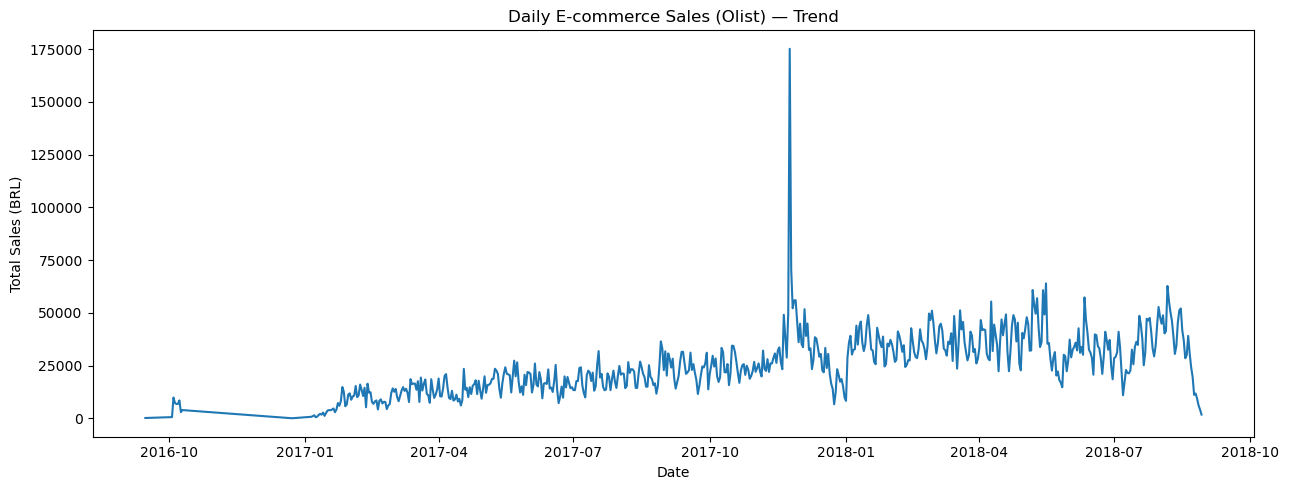

In [25]:
plt.figure()
plt.plot(daily_sales['date'], daily_sales['total_sales'])
plt.title("Daily E-commerce Sales (Olist) — Trend")
plt.xlabel("Date")
plt.ylabel("Total Sales (BRL)")
plt.tight_layout()
plt.show()

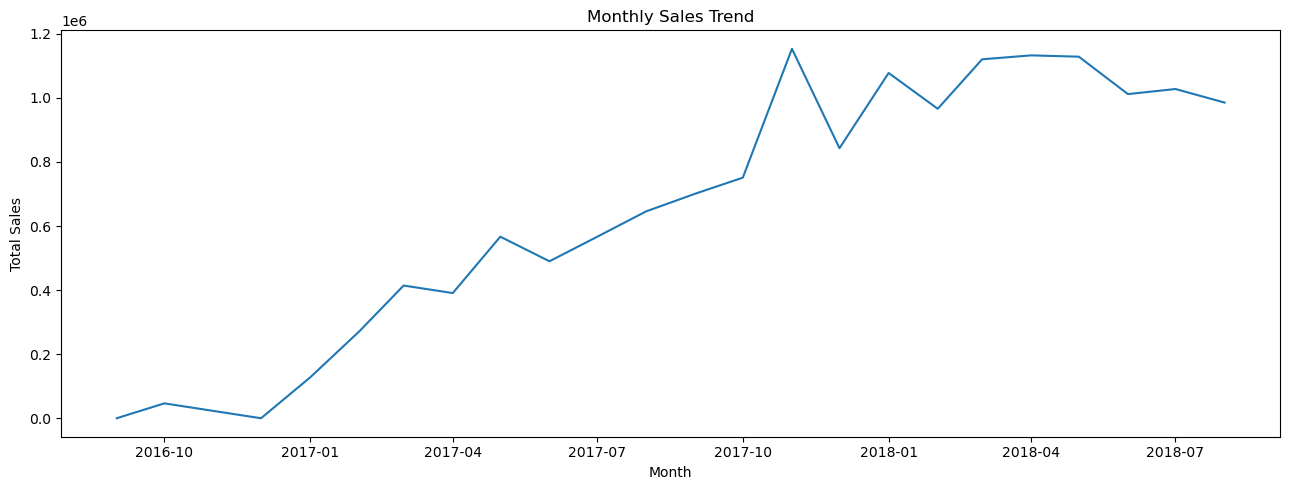

In [26]:
daily_sales['month'] = daily_sales['date'].dt.to_period('M')
monthly_sales = daily_sales.groupby('month')['total_sales'].sum().reset_index()
monthly_sales['month_str'] = monthly_sales['month'].dt.to_timestamp()
plt.figure()
plt.plot(monthly_sales['month_str'], monthly_sales['total_sales'])
plt.title("Monthly Sales Trend")
plt.xlabel("Month")
plt.ylabel("Total Sales")
plt.tight_layout()
plt.show()

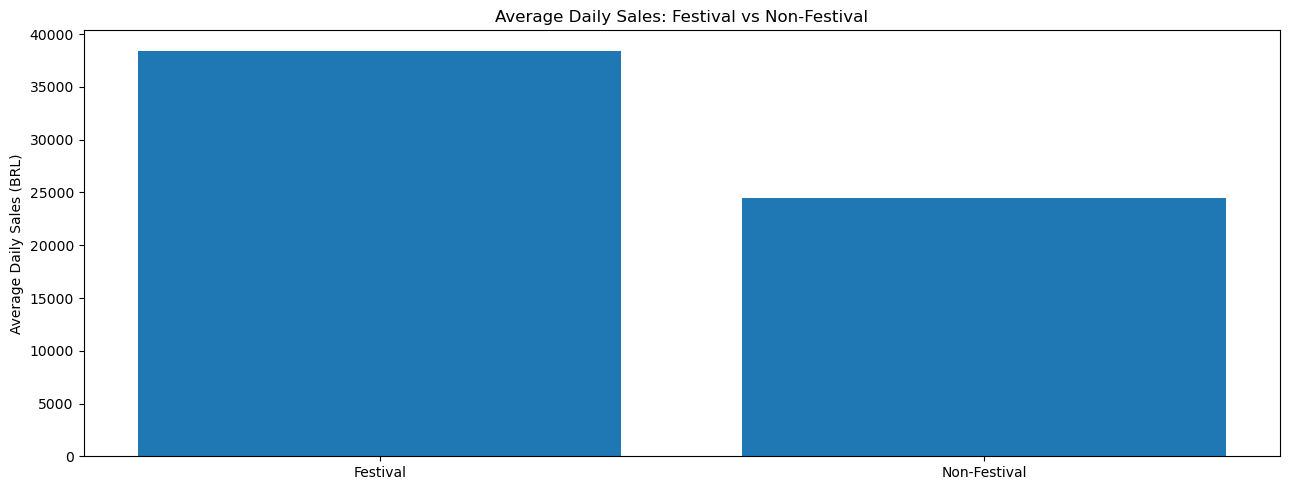

In [27]:
festival_avg = daily_sales[daily_sales['is_festival']]['total_sales'].mean()
non_festival_avg = daily_sales[~daily_sales['is_festival']]['total_sales'].mean()
plt.figure()
plt.bar(['Festival', 'Non-Festival'], [festival_avg, non_festival_avg])
plt.title("Average Daily Sales: Festival vs Non-Festival")
plt.ylabel("Average Daily Sales (BRL)")
plt.tight_layout()
plt.show()

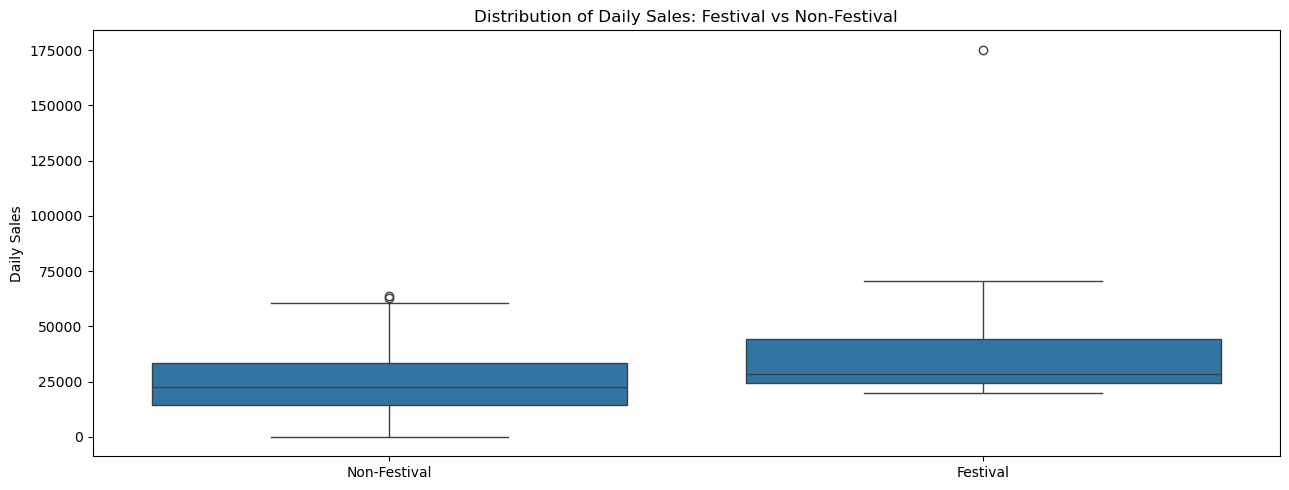

In [28]:
daily_sales_box = daily_sales.copy()
daily_sales_box['label'] = daily_sales_box['is_festival'].map({True:'Festival', False:'Non-Festival'})
plt.figure()
sns.boxplot(data=daily_sales_box, x='label', y='total_sales')
plt.title("Distribution of Daily Sales: Festival vs Non-Festival")
plt.xlabel("")
plt.ylabel("Daily Sales")
plt.tight_layout()
plt.show()

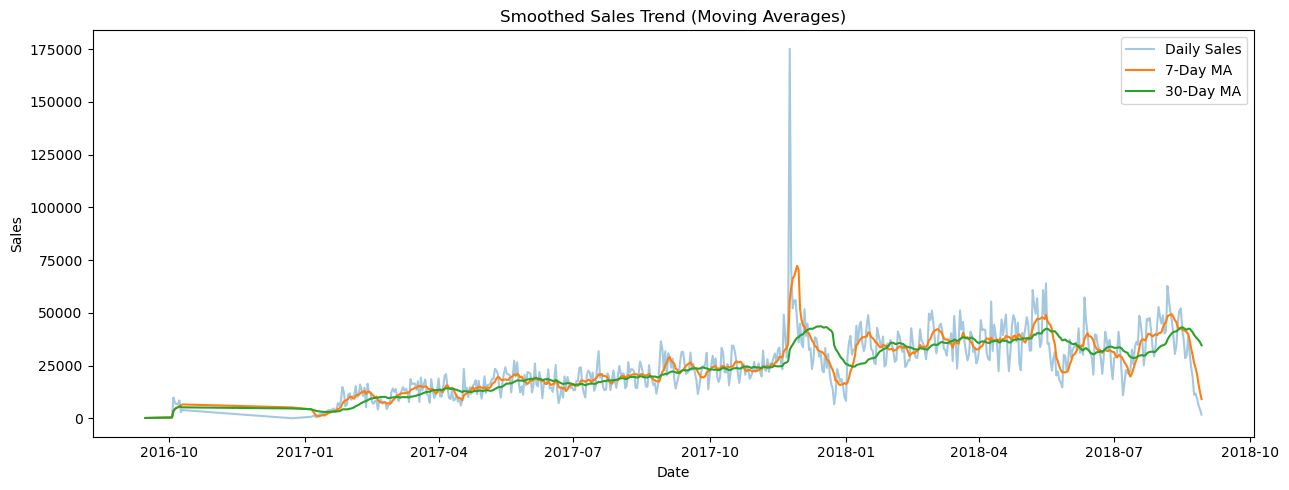

In [29]:
daily_sales = daily_sales.sort_values('date')
daily_sales['MA7'] = daily_sales['total_sales'].rolling(window=7, min_periods=1).mean()
daily_sales['MA30'] = daily_sales['total_sales'].rolling(window=30, min_periods=1).mean()
plt.figure()
plt.plot(daily_sales['date'], daily_sales['total_sales'], alpha=0.4, label='Daily Sales')
plt.plot(daily_sales['date'], daily_sales['MA7'], label='7-Day MA')
plt.plot(daily_sales['date'], daily_sales['MA30'], label='30-Day MA')
plt.title("Smoothed Sales Trend (Moving Averages)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.tight_layout()
plt.show()

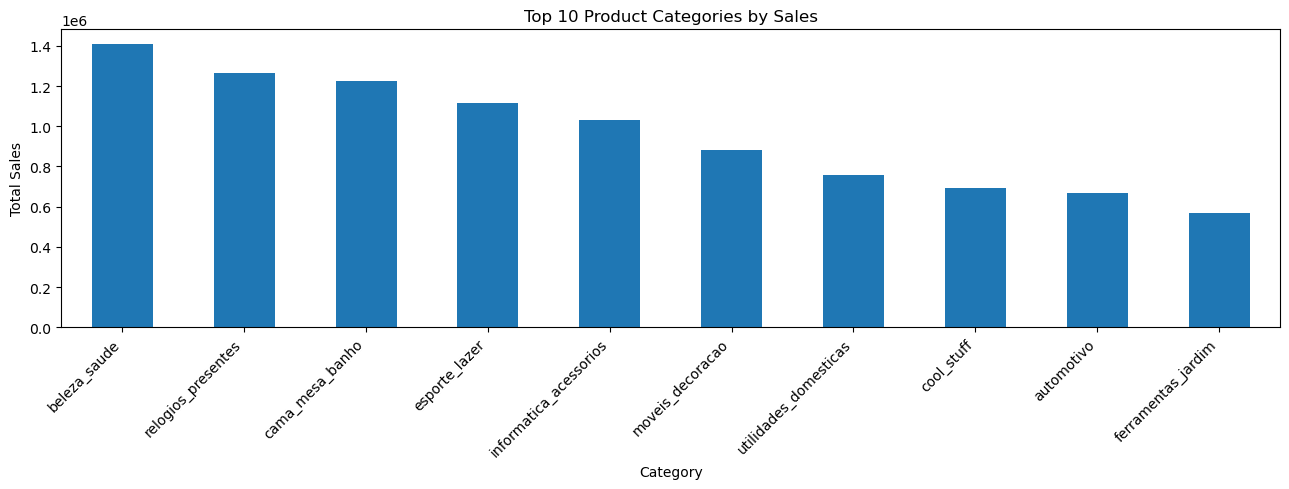

In [30]:
cat_sales = df.groupby('product_category_name')['total_sales'].sum().sort_values(ascending=False).head(10)
plt.figure()
cat_sales.plot(kind='bar')
plt.title("Top 10 Product Categories by Sales")
plt.xlabel("Category")
plt.ylabel("Total Sales")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
cat = df.copy()
cat['is_festival'] = cat['date'].apply(lambda x: any(pd.to_datetime(start) <= x <= pd.to_datetime(end) for start, end in festival_windows))
cat_group = cat.groupby(['product_category_name','is_festival'])['total_sales'].sum().unstack(fill_value=0)
cat_group['festival_lift'] = cat_group.get(True, 0) - cat_group.get(False, 0)
cat_group_top = cat_group.sort_values('festival_lift', ascending=False).head(10)['festival_lift']
plt.figure()
cat_group_top.plot(kind='bar')
plt.title("Top Categories with Highest Festival Season Sales Increase")
plt.ylabel("Festival Lift (Sales Difference)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

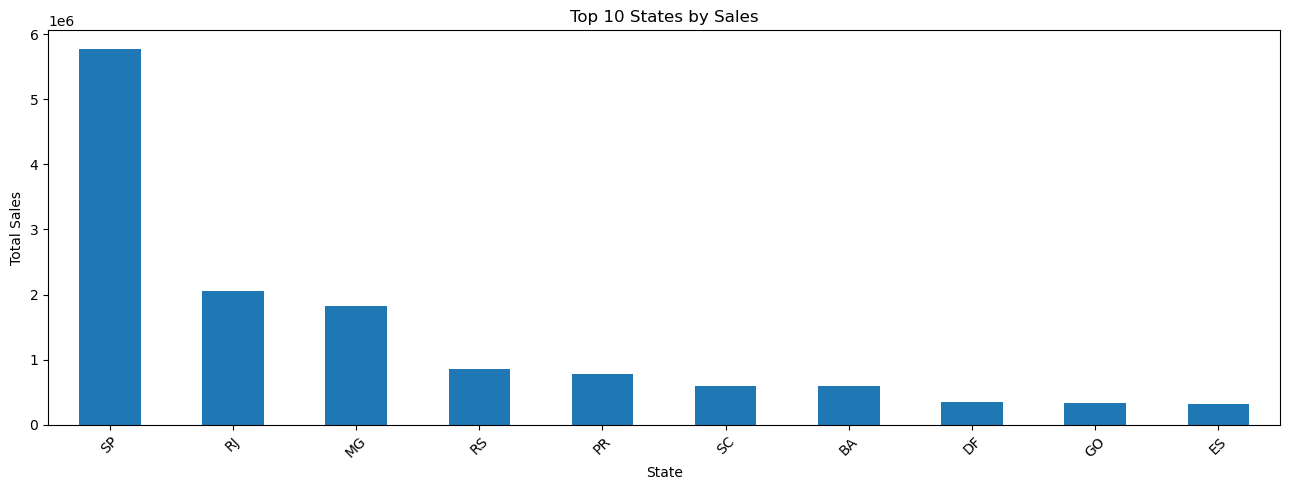

In [33]:
state_sales = df.groupby('customer_state')['total_sales'].sum().sort_values(ascending=False).head(10)
plt.figure()
state_sales.plot(kind='bar')
plt.title("Top 10 States by Sales")
plt.xlabel("State")
plt.ylabel("Total Sales")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


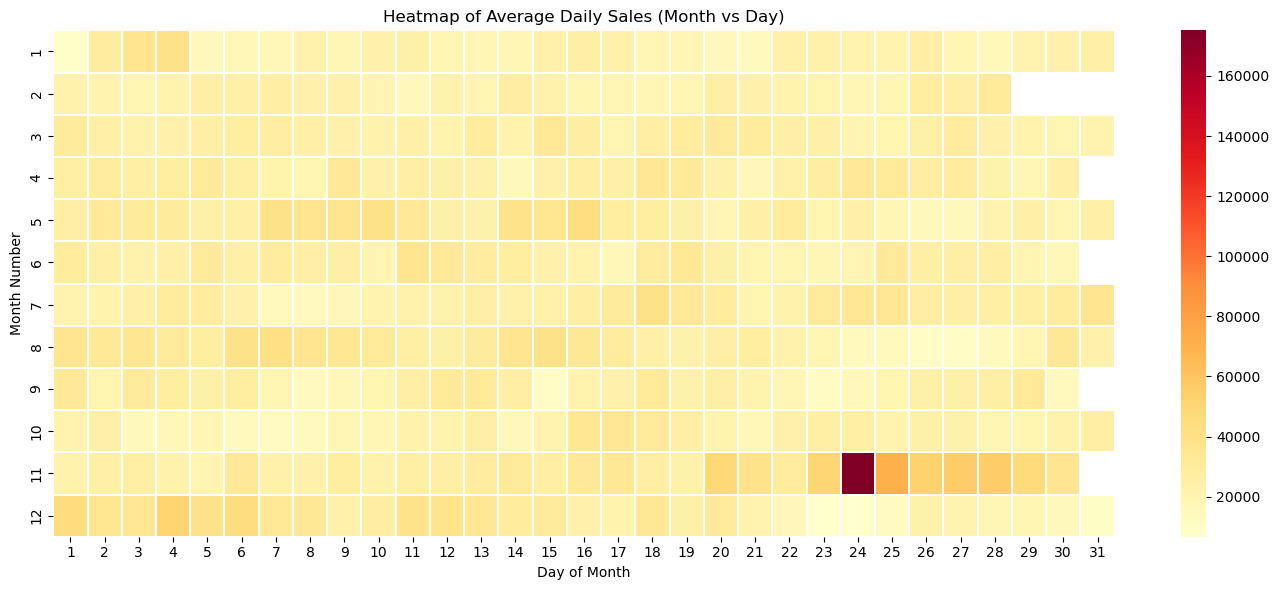

In [34]:
daily_sales['month_num'] = daily_sales['date'].dt.month
daily_sales['day'] = daily_sales['date'].dt.day
pivot = daily_sales.pivot_table(values='total_sales', index='month_num', columns='day', aggfunc='mean')
plt.figure(figsize=(14,6))
sns.heatmap(pivot, cmap="YlOrRd", linewidths=0.3)
plt.title("Heatmap of Average Daily Sales (Month vs Day)")
plt.xlabel("Day of Month")
plt.ylabel("Month Number")
plt.tight_layout()
plt.show()

In [35]:
daily_sales.to_csv("daily_sales_summary.csv", index=False)
cat_group.to_csv("category_festival_lift.csv")
state_sales.to_csv("state_sales_top10.csv")
print("Saved daily_sales_summary.csv, category_festival_lift.csv, state_sales_top10.csv")

NameError: name 'cat_group' is not defined